
## 서비스 가입 여부 및 요금 기반 고객 이탈 예측 및 분석

--- 
**데이터**: churn-bigml-80
**분석 목표**: 고객의 이탈을 예측하고, **"어떻게 해야 고객을 이탈하지 않게 만드는가?"** 에 대한 근거를 찾습니다.

---

## 분석 목표 정의
- Target : Churn
- 어떤 고객이 이탈을 하게 되는가
- 잠정 이탈 고객을 예측하고 이탈방지를 어떻게 해야하는가


---

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster import hierarchy
from scipy.ndimage import gaussian_filter1d

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score
)
from sklearn.inspection import permutation_importance, partial_dependence

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


In [2]:
# 데이터 로드
import pandas as pd
df = pd.read_csv("C:/Users/허재민/Desktop/archive/churn-bigml-80.csv", sep=",")
df_test = pd.read_csv("C:/Users/허재민/Desktop/archive/churn-bigml-20.csv", sep=",")

print(f"📊 Dataset Shape: {df.shape}")
print(f"\n📋 Columns ({len(df.columns)}개):")
print(df.columns.tolist())

# 결측치 확인
print(f"\n🔍 Missing Values:")
print(df.isnull().sum())

# 샘플 확인
print(f"\n📄 Sample Data:")
display(df.head(10))
df.head()
df.dtypes

📊 Dataset Shape: (2666, 20)

📋 Columns (20개):
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

🔍 Missing Values:
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn       

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,Yes,No,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,No,Yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,Yes,No,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,WV,141,415,Yes,Yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False
9,RI,74,415,No,No,0,187.7,127,31.91,163.4,148,13.89,196.0,94,8.82,9.1,5,2.46,0,False


State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [3]:
# 수치변형 0 = False, 1 = True
df["Churn"] = df["Churn"].astype(int)
binary_cols = ["International plan", "Voice mail plan"]

df[binary_cols] = df[binary_cols].replace(
    {"Yes": 1, "No": 0}
).astype(int)

# 샘플 확인
print(f"\n📄 Sample Data:")
display(df.head(10))
df.head()
df.dtypes


📄 Sample Data:


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
5,AL,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
6,MA,121,510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0
7,MO,147,415,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0
8,WV,141,415,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0
9,RI,74,415,0,0,0,187.7,127,31.91,163.4,148,13.89,196.0,94,8.82,9.1,5,2.46,0,0


State                      object
Account length              int64
Area code                   int64
International plan          int64
Voice mail plan             int64
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                       int64
dtype: object

## 이진형 / 범주형 / 수치형 나누기

In [4]:
binary_cols = [
    'International plan',
    'Voice mail plan'
]

categorical_cols = [
    'State',
    'Area code'
]

numeric_cols = [
    'Account length',
    'Number vmail messages',
    'Total day minutes', 'Total day calls', 'Total day charge',
    'Total eve minutes', 'Total eve calls', 'Total eve charge',
    'Total night minutes', 'Total night calls', 'Total night charge',
    'Total intl minutes', 'Total intl calls', 'Total intl charge',
    'Customer service calls'
]

## 타겟 비율 확인 85% vs 15%

In [5]:
plt.figure()
plt.bar(
    churn_ratio.index,
    churn_ratio.values,
    color='seagreen',        
    edgecolor='black',    
    linewidth=1.5         
)

plt.xticks(churn_ratio.index, ['No Churn', 'Churn'])
plt.ylabel('Proportion')
plt.title('Churn Rate Distribution')

plt.show()

churn_dist = (
    df[target]
    .value_counts()
    .to_frame('count')
    .assign(ratio=lambda x: x['count'] / x['count'].sum())
)

churn_dist


NameError: name 'churn_ratio' is not defined

<Figure size 640x480 with 0 Axes>

## 수치형 컬럼 분포 요약 통계

In [ ]:
numeric_summary = (
    df[numeric_cols]
    .describe()
    .T
    .loc[:, ['mean', '50%', 'std', 'min', '25%', '75%', 'max']]
    .rename(columns={'50%': 'median'})
)

numeric_summary

,mean,median,std,min,25%,75%,max
Account length,100.620405,100.00,39.563974,1.00,73.0000,127.000,243.00
Number vmail messages,8.021755,0.00,13.612277,0.00,0.0000,19.000,50.00
Total day minutes,179.481620,179.95,54.210350,0.00,143.4000,215.900,350.80
Total day calls,100.310203,101.00,19.988162,0.00,87.0000,114.000,160.00
Total day charge,30.512404,30.59,9.215733,0.00,24.3800,36.700,59.64
Total eve minutes,200.386159,200.90,50.951515,0.00,165.3000,235.100,363.70
Total eve calls,100.023631,100.00,20.161445,0.00,87.0000,114.000,170.00
Total eve charge,17.033072,17.08,4.330864,0.00,14.0500,19.980,30.91
Total night minutes,201.168942,201.15,50.780323,43.70,166.9250,236.475,395.00
Total night calls,100.106152,100.00,19.418459,33.00,87.0000,113.000,166.00


## 수치형 히스토그램

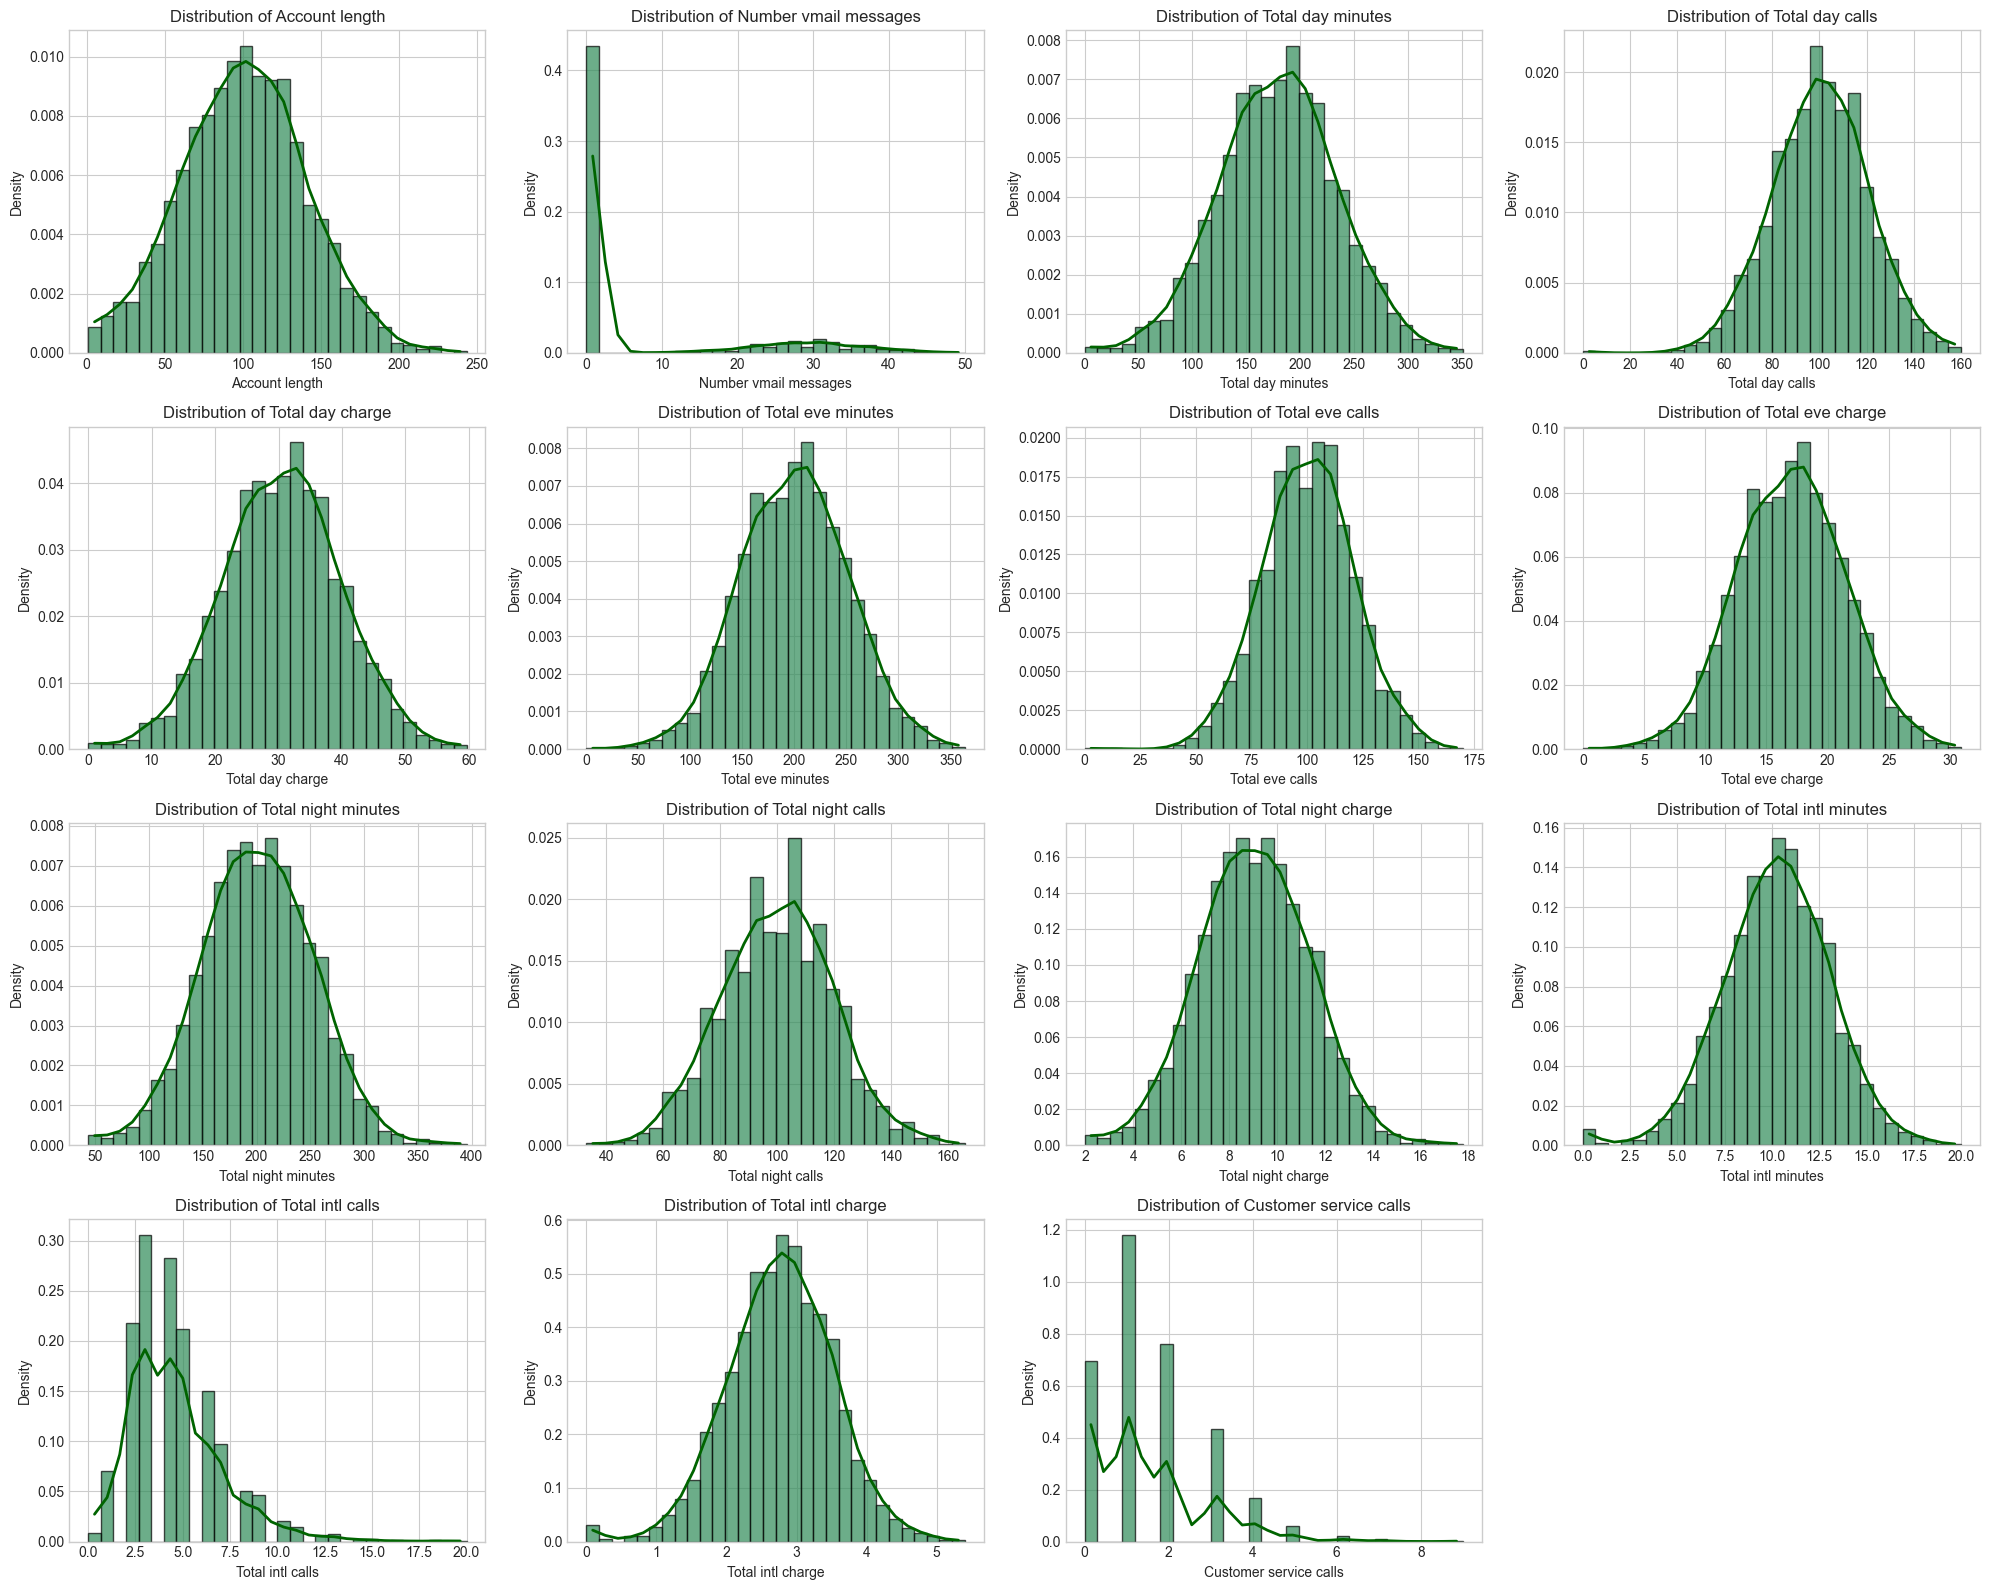


📊 Skewness & Kurtosis Summary (절댓값 큰 순서):


,Feature,Skewness,Kurtosis
12,Total intl calls,1.358769,3.266619
1,Number vmail messages,1.271774,-0.040158
14,Customer service calls,1.095176,1.813987
13,Total intl charge,-0.224569,0.617537
11,Total intl minutes,-0.224434,0.616555
3,Total day calls,-0.128267,0.289549
0,Account length,0.079023,-0.138313
6,Total eve calls,-0.065209,0.189396
2,Total day minutes,-0.053106,0.019364
4,Total day charge,-0.053087,0.019502


In [ ]:
target = 'Churn'

n = len(numeric_cols)
cols = 4
rows = int(np.ceil(n / cols))

plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(rows, cols, i)

    counts, bins, _ = ax.hist(
        df[col],
        bins=30,
        color='seagreen',
        edgecolor='black',
        alpha=0.7,
        density=True
    )

    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    counts_smooth = gaussian_filter1d(counts, sigma=1)

    ax.plot(
        bin_centers,
        counts_smooth,
        color='darkgreen',
        linewidth=2
    )

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Skewness 요약 테이블
skew_summary = pd.DataFrame({
    'Feature': numeric_cols,
    'Skewness': [df[col].skew() for col in numeric_cols],
    'Kurtosis': [df[col].kurtosis() for col in numeric_cols]
}).sort_values('Skewness', key=abs, ascending=False)

print("\n📊 Skewness & Kurtosis Summary (절댓값 큰 순서):")
display(skew_summary)


## Total intl calls
- 0~5에 대부분 집중
- 오른쪽 꼬리 길음


## Number vmail messages
- 0 근처에 값이 몰려 있음
- 20~50 구간에 긴 오른쪽 꼬리


## Customer service calls
- 0~2에 값이 많이 몰림
- 강한 양의 왜도

랜덤 포레스트 - 왜도 이상치 비선형에 강함 = 건드릴 필요 x

## 수치형 박스플롯

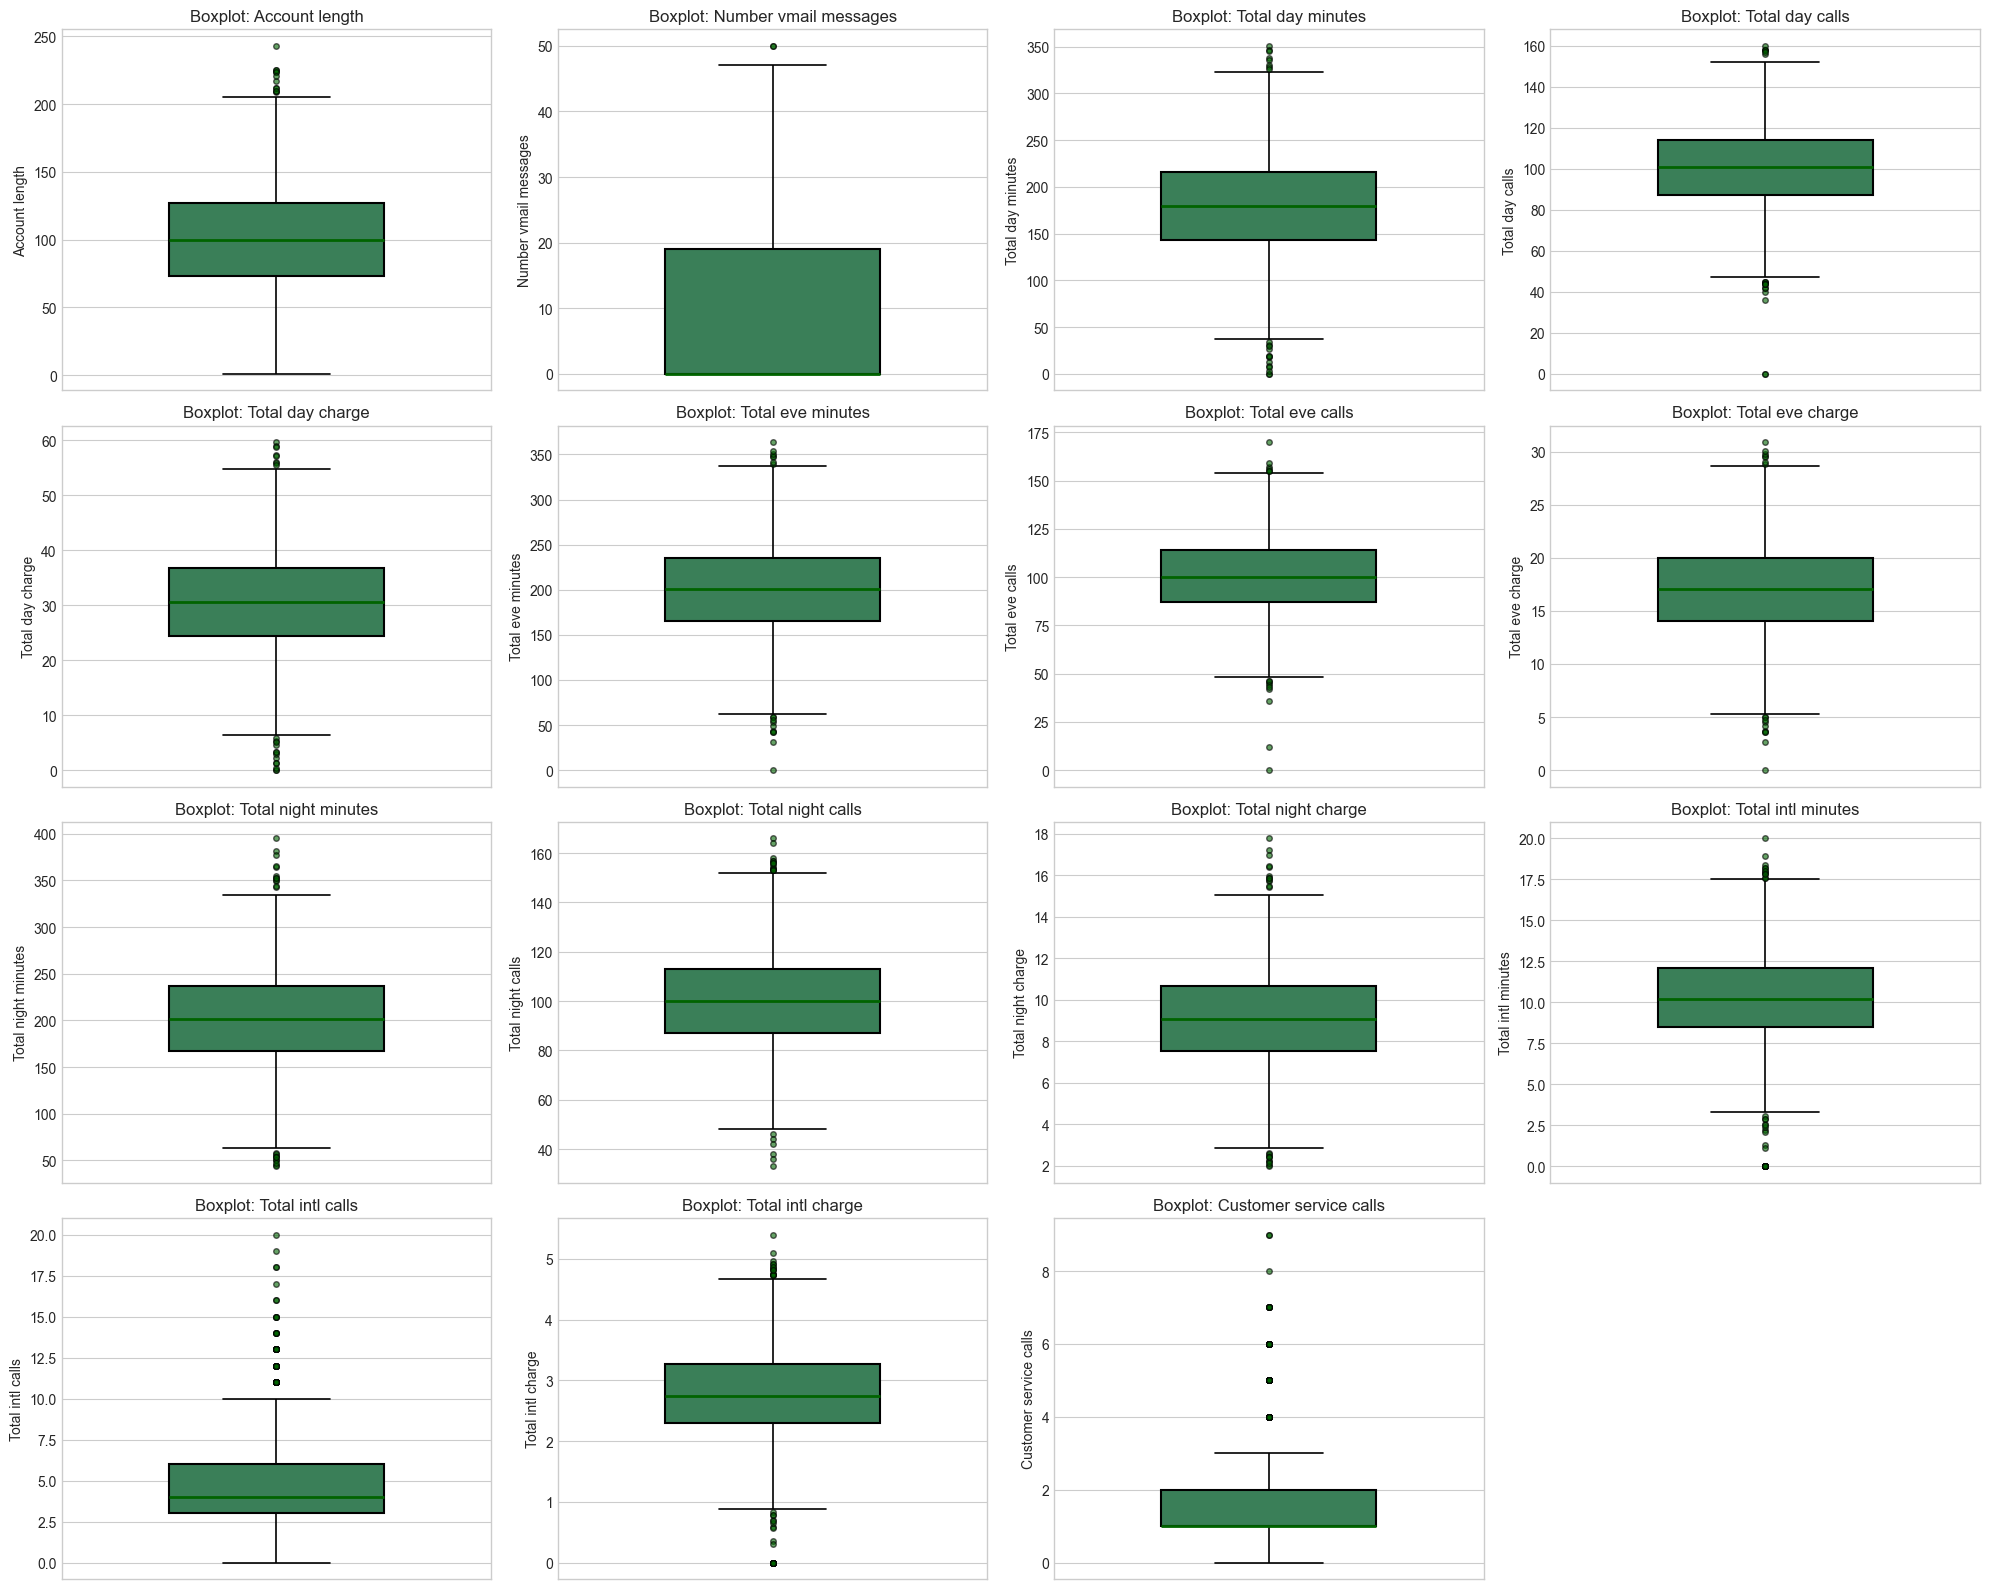

In [ ]:
plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(rows, cols, i)

    sns.boxplot(
        y=df[col],
        ax=ax,
        color='seagreen',                
        width=0.5,
        linewidth=1.5,
        boxprops=dict(edgecolor='black'),
        whiskerprops=dict(color='black', linewidth=1.2),
        capprops=dict(color='black', linewidth=1.2),
        medianprops=dict(color='darkgreen', linewidth=2),
        flierprops=dict(                 
            marker='o',
            markersize=4,
            markerfacecolor='darkgreen',
            markeredgecolor='black',
            alpha=0.6
        )
    )

    ax.set_title(f'Boxplot: {col}')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()




## 이진형 컬럼 비율

In [ ]:
for col in binary_cols:
    print(f'\n[{col}]')
    display(
        df[col]
        .value_counts()
        .to_frame('count')
        .assign(ratio=lambda x: x['count'] / x['count'].sum())
    )


[International plan]


,count,ratio
International plan,,
0,2396,0.898725
1,270,0.101275



[Voice mail plan]


,count,ratio
Voice mail plan,,
0,1933,0.725056
1,733,0.274944


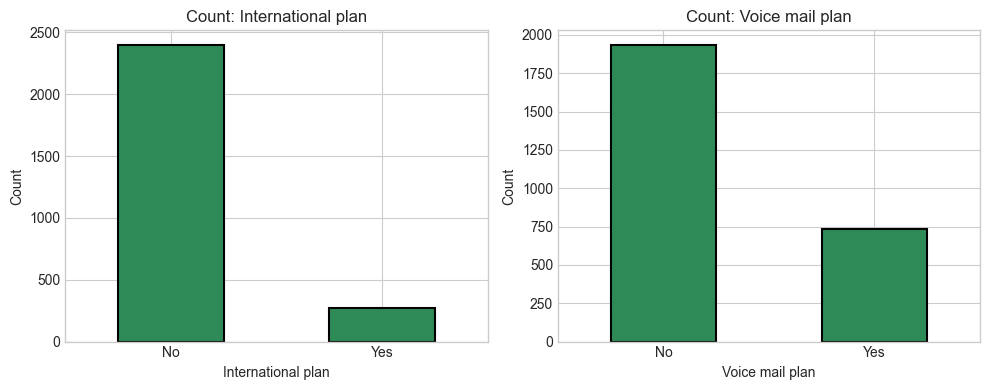

In [ ]:
plt.figure(figsize=(10, 4))

for i, col in enumerate(binary_cols, 1):
    ax = plt.subplot(1, len(binary_cols), i)

    df[col].value_counts().sort_index().plot(
        kind='bar',
        ax=ax,
        color='seagreen',     # 막대 내부 색
        edgecolor='black',    # 막대 테두리 색
        linewidth=1.5
    )

    ax.set_title(f'Count: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_xticklabels(['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

## 범주형 컬럼 범주 수

In [ ]:
for col in categorical_cols:
    print(f'\n[{col}] 범주 수:', df[col].nunique())
    display(df[col].value_counts().head(10))


[State] 범주 수: 51


State
WV    88
MN    70
NY    68
VA    67
AL    66
OH    66
WY    66
OR    62
NV    61
WI    61
Name: count, dtype: int64


[Area code] 범주 수: 3


Area code
415    1318
510     679
408     669
Name: count, dtype: int64

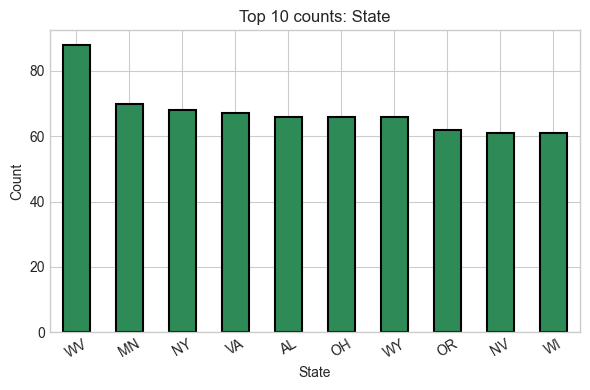

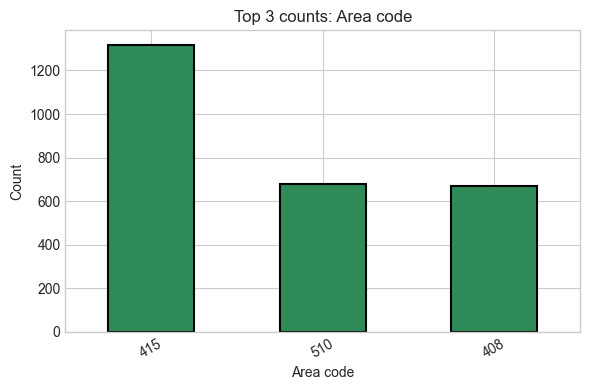

In [ ]:
for col in categorical_cols:
    top_n = 10 if df[col].nunique() > 10 else df[col].nunique()

    ax = (
        df[col]
        .value_counts()
        .head(top_n)
        .plot(
            kind='bar',
            figsize=(6, 4),
            color='seagreen',     # 막대 내부 색
            edgecolor='black',    # 막대 테두리
            linewidth=1.5
        )
    )

    ax.set_title(f'Top {top_n} counts: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


    plt.tight_layout()
    plt.show()


## 이변량 분석

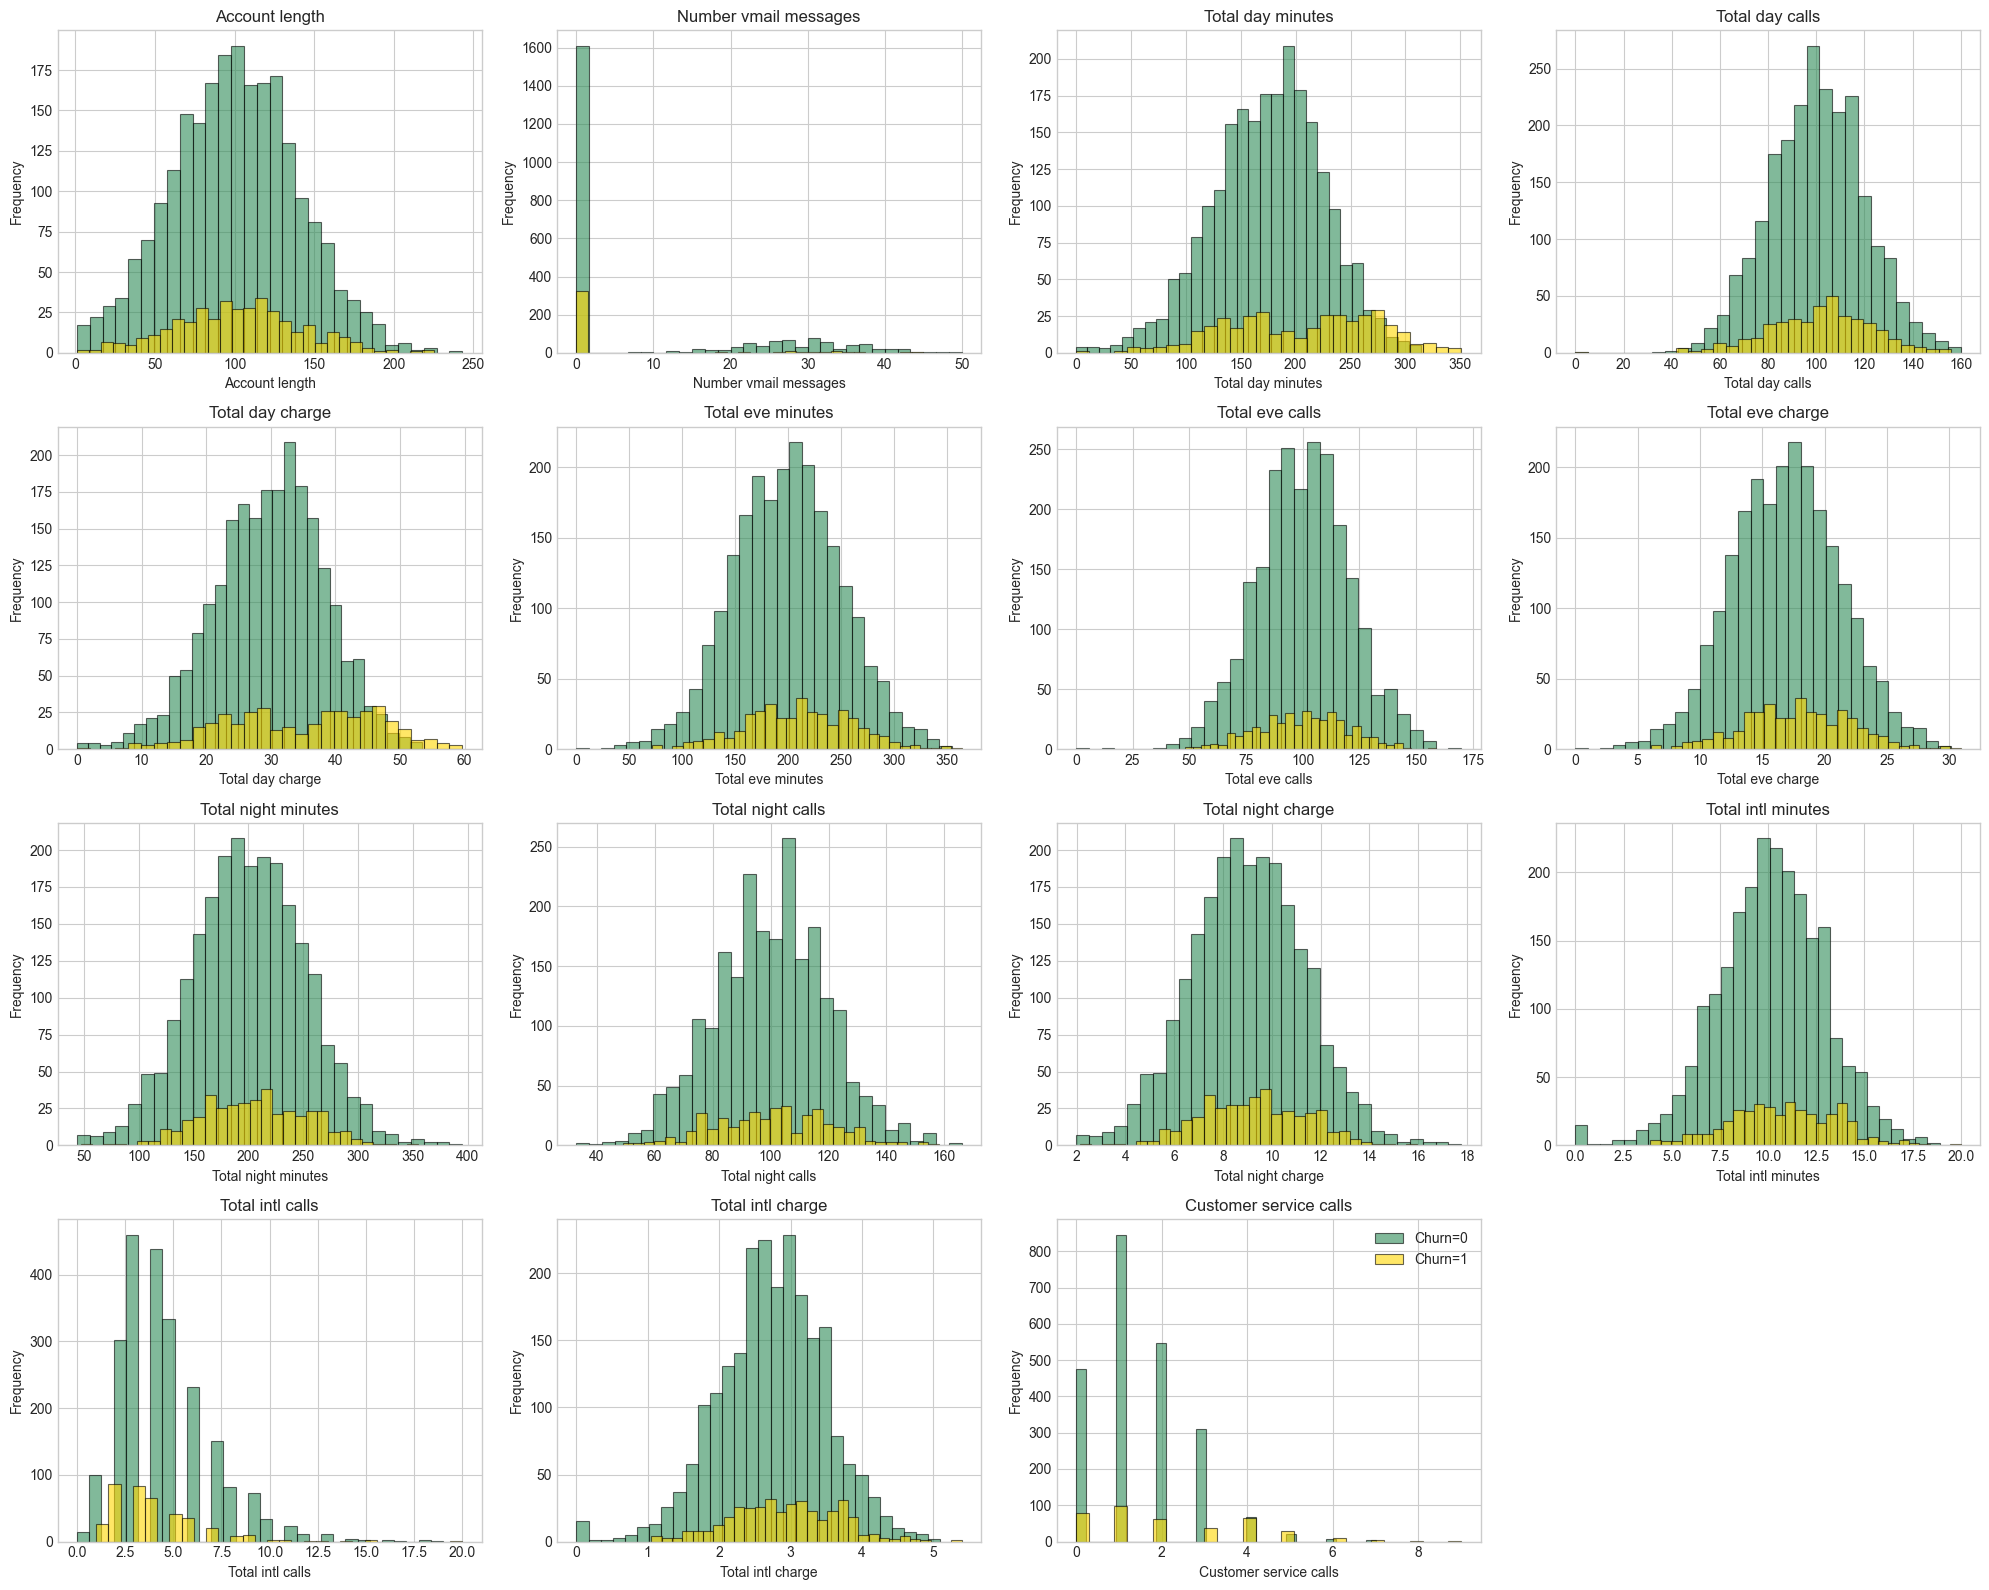

In [ ]:
numeric_cols = [
    'Account length',
    'Number vmail messages',
    'Total day minutes', 'Total day calls', 'Total day charge',
    'Total eve minutes', 'Total eve calls', 'Total eve charge',
    'Total night minutes', 'Total night calls', 'Total night charge',
    'Total intl minutes', 'Total intl calls', 'Total intl charge',
    'Customer service calls'
]

n = len(numeric_cols)
cols = 4
rows = int(np.ceil(n / cols))

plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(rows, cols, i)

    churn0 = df[df['Churn'] == 0][col]
    churn1 = df[df['Churn'] == 1][col]

    ax.hist(
        churn0,
        bins=30,
        alpha=0.6,
        label='Churn=0',
        color='seagreen',
        edgecolor='black',
        linewidth=0.8
    )

    ax.hist(
        churn1,
        bins=30,
        alpha=0.6,
        label='Churn=1',
        color='gold',
        edgecolor='black',
        linewidth=0.8
    )

    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# 전체 figure 기준으로 legend 한 번만
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



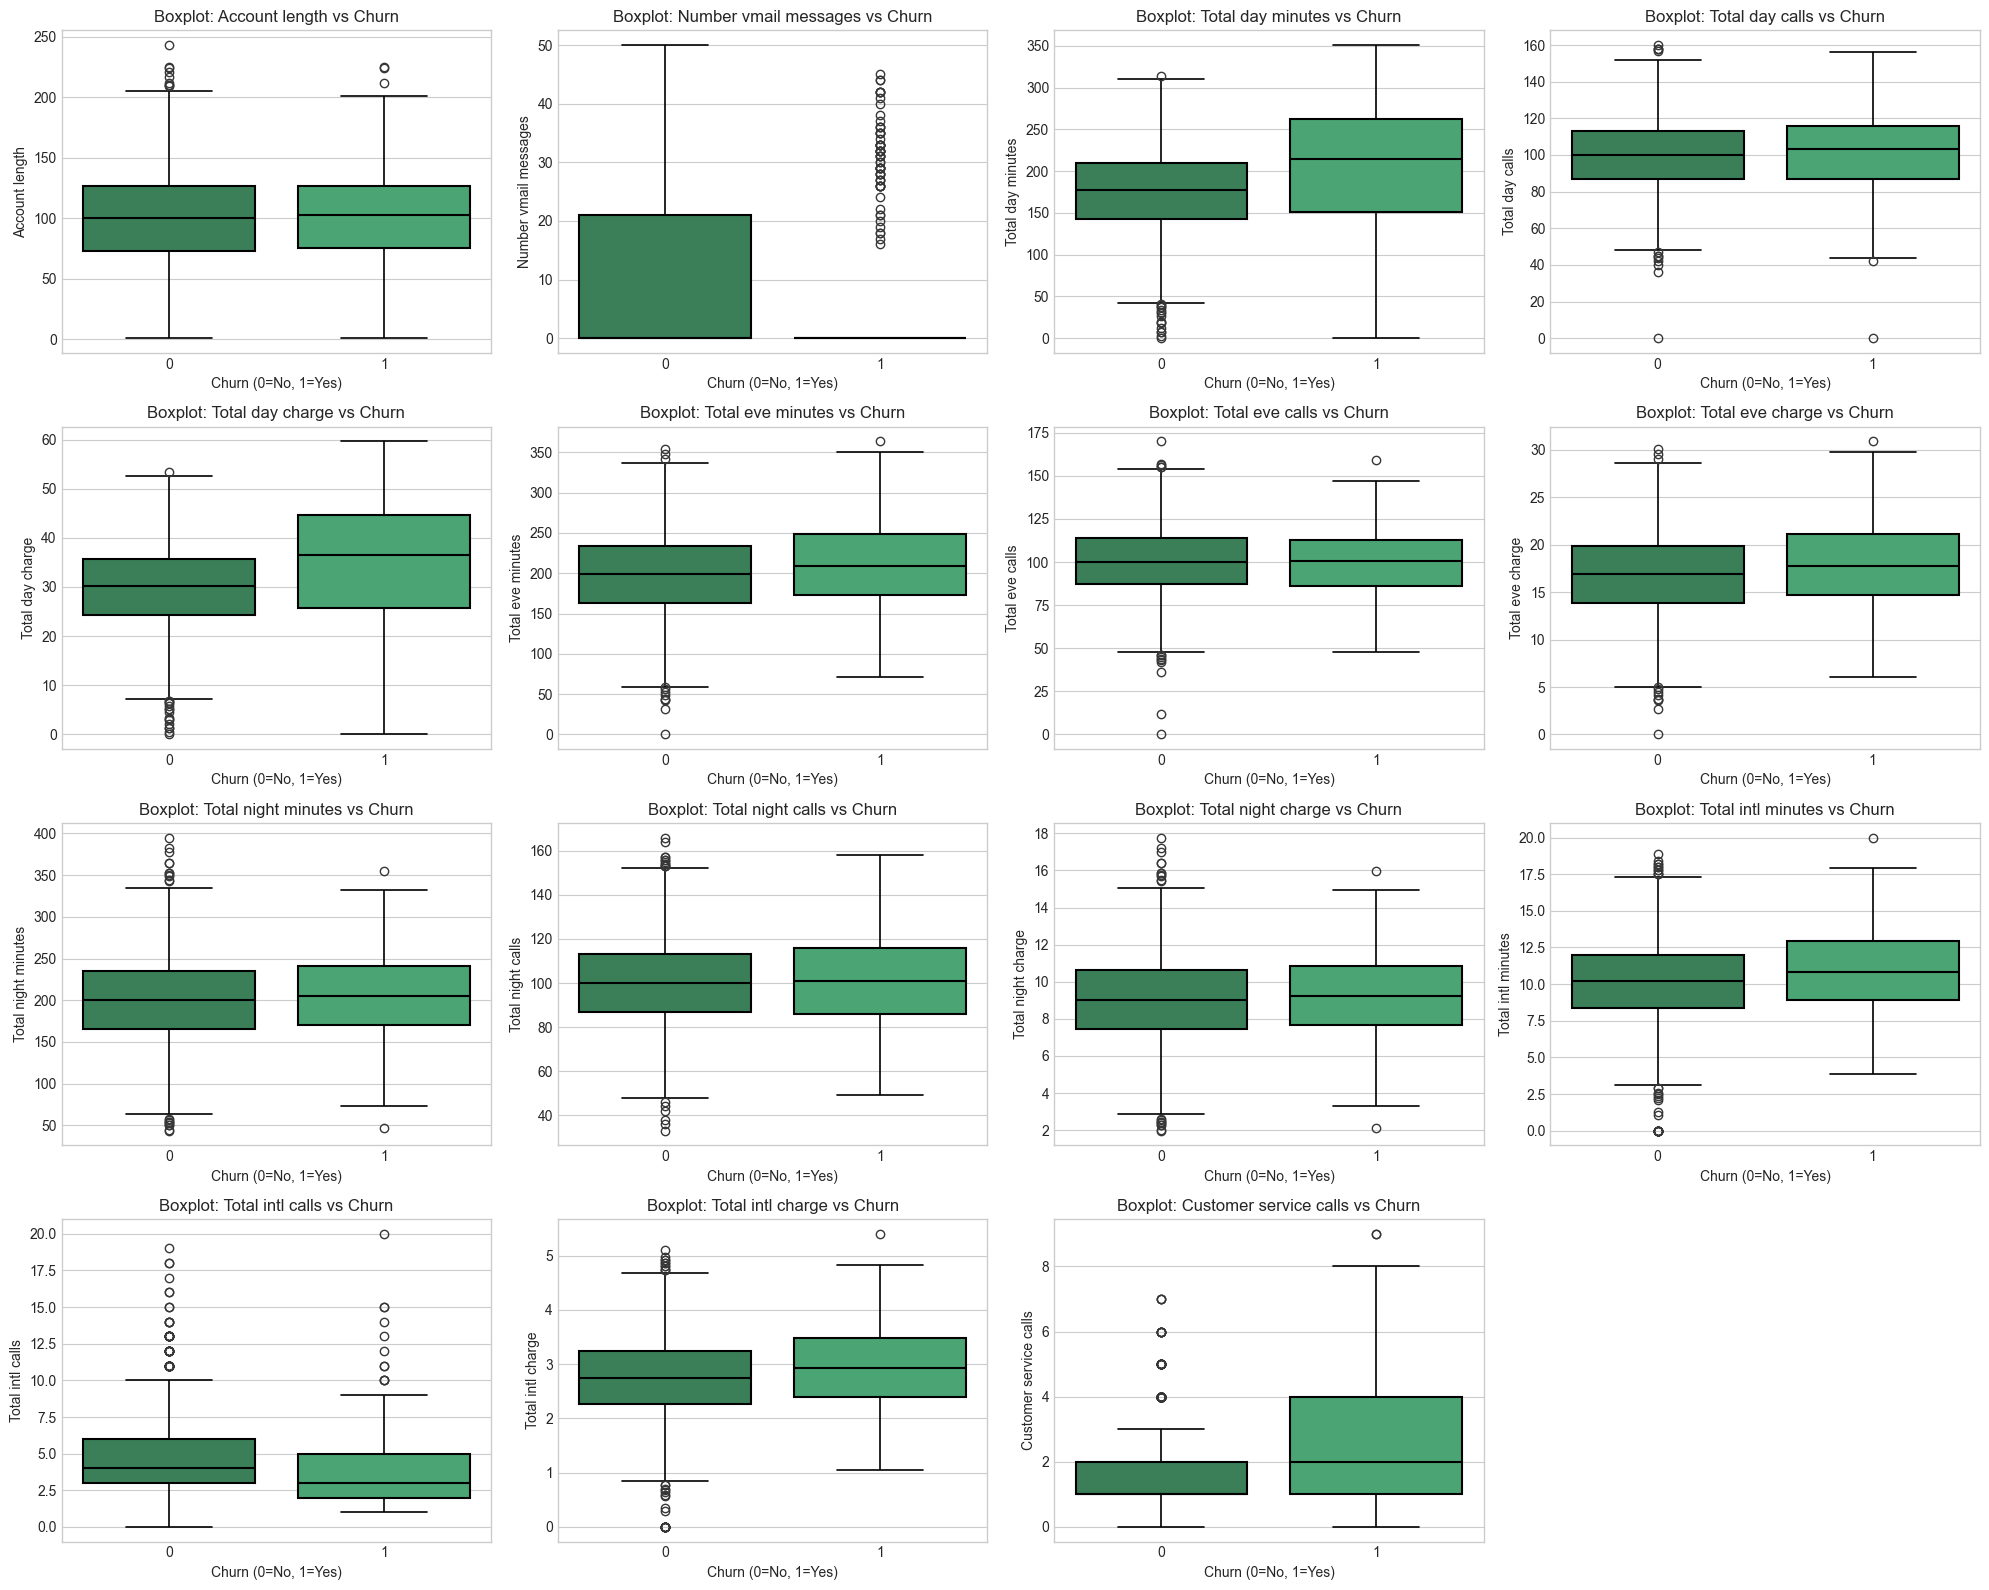

In [ ]:
n = len(numeric_cols)
cols = 4
rows = int(np.ceil(n / cols))

plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(rows, cols, i)
    
    sns.boxplot(
        x=target,
        y=col,
        data=df,
        ax=ax,
        palette=['seagreen', 'mediumseagreen'],
        linewidth=1.5,
        boxprops=dict(edgecolor='black'),
        whiskerprops=dict(color='black', linewidth=1.2),
        capprops=dict(color='black', linewidth=1.2),
        medianprops=dict(color='black', linewidth=1.5)
    )
    
    ax.set_title(f'Boxplot: {col} vs Churn')
    ax.set_xlabel('Churn (0=No, 1=Yes)')
    ax.tick_params(axis='x', labelrotation=0)

plt.tight_layout()
plt.show()


In [ ]:
outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()

    outlier_summary.append({
        'column': col,
        'outlier_count': int(n_outliers),
        'outlier_ratio(%)': round(n_outliers / len(df) * 100, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values(
    'outlier_count', ascending=False
)

display(outlier_df)


,column,outlier_count,outlier_ratio(%)
14,Customer service calls,210,7.88
12,Total intl calls,66,2.48
13,Total intl charge,40,1.50
11,Total intl minutes,37,1.39
8,Total night minutes,22,0.83
10,Total night charge,22,0.83
2,Total day minutes,21,0.79
4,Total day charge,21,0.79
9,Total night calls,19,0.71
3,Total day calls,18,0.68


Customer service calls — 7.88%

Total intl calls / minutes / charge - 1.39 ~ 2.48%

극단값을 가진 고객집단은 대부분 고객센터 문의 전화와 국제전화 와 관련해서 포진해있다 이 집단값이 이탈률과 관련있는지 확인 요망

## 고객센터 문의 전화 횟수 그룹화

In [ ]:
df['CS_group'] = pd.cut(
    df['Customer service calls'],
    bins=[-1, 0, 3, df['Customer service calls'].max()],
    labels=['0', '1-3', '4+']
)

df.groupby('CS_group')[target].mean()


CS_group
0      0.142342
1-3    0.104156
4+     0.528571
Name: Churn, dtype: float64

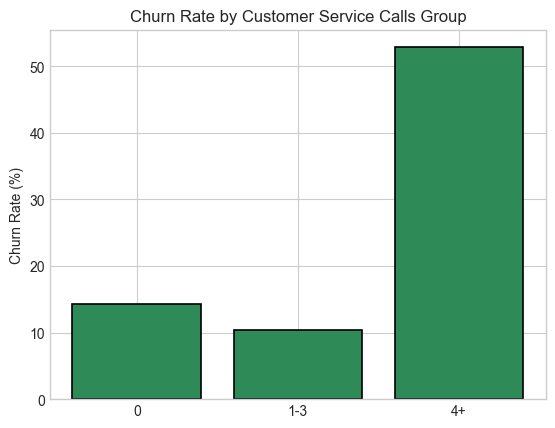

In [ ]:
churn_rate = df.groupby('CS_group')[target].mean() * 100

plt.figure()
plt.bar(
    churn_rate.index,
    churn_rate.values,
    color='seagreen',      
    edgecolor='black',     
    linewidth=1.2          
)
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Customer Service Calls Group')
plt.show()

고객센터에 한번도 전화 하지 않은 고객보다 1번이라도 전화한 고객이 좀더 이탈률이 낮고 특정 구간을 넘어서게 되면 폭발적으로 이탈하게 되는 것으로 보아 고객센터 문의 횟수 증가는 강력한 이탈 신호로 볼 수 있다.

## 이진형 이변량 분석

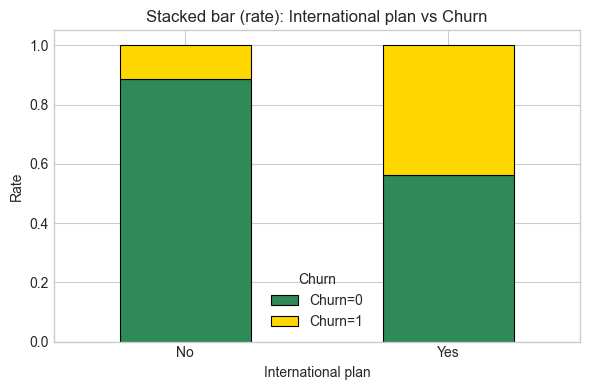


[Crosstab - rate] International plan
Churn                      0         1
International plan                    
0                   0.887312  0.112688
1                   0.562963  0.437037


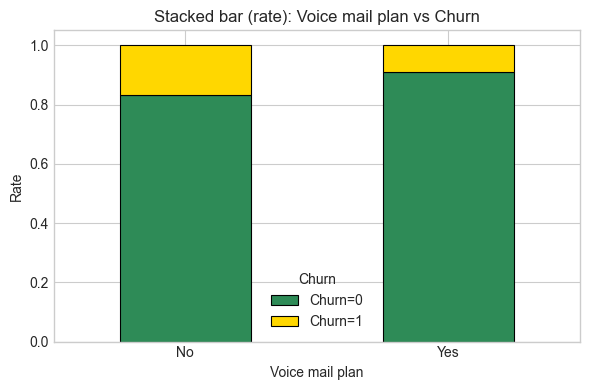


[Crosstab - rate] Voice mail plan
Churn                   0         1
Voice mail plan                    
0                0.832902  0.167098
1                0.911323  0.088677


In [ ]:
def binary_crosstab_plot(df, col, target='Churn', labels=('No','Yes')):
    ct = pd.crosstab(df[col], df[target], normalize='index')
    ct = ct.reindex(index=[0, 1], fill_value=0)

    ax = ct.plot(
        kind='bar',
        stacked=True,
        figsize=(6, 4),
        color=['seagreen', 'gold'],
        edgecolor='black',
        linewidth=0.8
    )

    ax.set_title(f'Stacked bar (rate): {col} vs Churn')
    ax.set_ylabel('Rate')
    ax.set_xlabel(col)
    ax.set_xticklabels(labels, rotation=0)

    # 범례 이름 정리
    ax.legend(['Churn=0', 'Churn=1'], title='Churn')

    plt.tight_layout()
    plt.show()

    print(f'\n[Crosstab - rate] {col}')
    print(ct)


for col in binary_cols:
    binary_crosstab_plot(df, col, target=target)


### 국제전화 요금제 가입여부에 따라 이탈률이 차이가 크다.

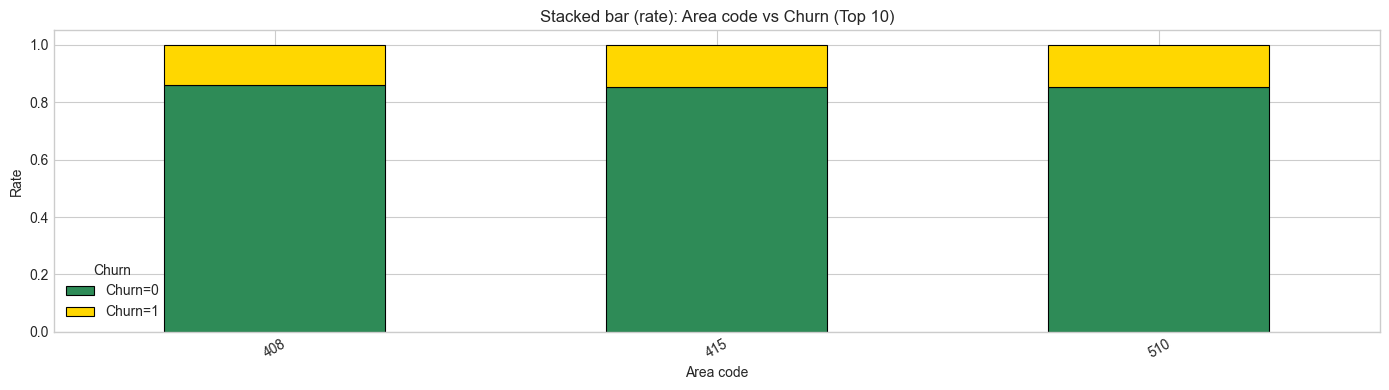


[Crosstab - rate] Area code (Top 10)
Churn             0         1
Area code                    
408        0.859492  0.140508
415        0.852049  0.147951
510        0.854197  0.145803


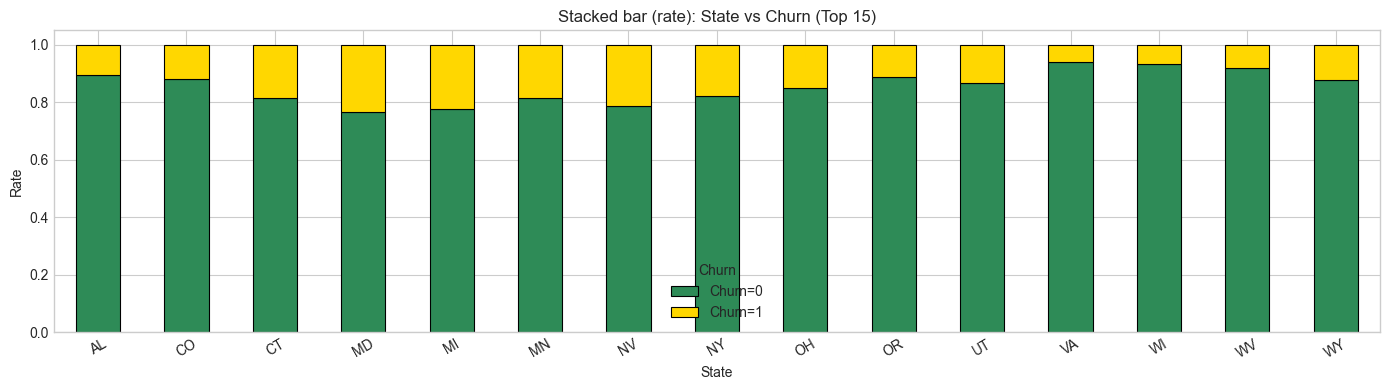


[Crosstab - rate] State (Top 15)
Churn         0         1
State                    
AL     0.893939  0.106061
CO     0.881356  0.118644
CT     0.813559  0.186441
MD     0.766667  0.233333
MI     0.775862  0.224138
MN     0.814286  0.185714
NV     0.786885  0.213115
NY     0.823529  0.176471
OH     0.848485  0.151515
OR     0.887097  0.112903
UT     0.866667  0.133333
VA     0.940299  0.059701
WI     0.934426  0.065574
WV     0.920455  0.079545
WY     0.878788  0.121212


In [ ]:
def categorical_crosstab_plot(df, col, target='Churn', top_n=10):
    top_categories = df[col].value_counts().head(top_n).index
    d = df[df[col].isin(top_categories)]

    ct = pd.crosstab(d[col], d[target], normalize='index')

    ax = ct.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 4),
        color=['seagreen', 'gold'],
        edgecolor='black',
        linewidth=0.8
    )

    ax.set_title(f'Stacked bar (rate): {col} vs Churn (Top {top_n})')
    ax.set_ylabel('Rate')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', labelrotation=30)

    ax.legend(['Churn=0', 'Churn=1'], title='Churn')

    plt.tight_layout()
    plt.show()

    print(f'\n[Crosstab - rate] {col} (Top {top_n})')
    print(ct)


categorical_crosstab_plot(df, 'Area code', target=target, top_n=10)
categorical_crosstab_plot(df, 'State', target=target, top_n=15)

## 수치형 컬럼 평균차이(diff)와 P-Value

In [ ]:
from scipy.stats import ttest_ind
ttest_results = []

for col in numeric_cols:
    g0 = df[df[target] == 0][col].dropna()
    g1 = df[df[target] == 1][col].dropna()

    stat, p = ttest_ind(g0, g1, equal_var=False)

    ttest_results.append({
        'feature': col,
        'mean_churn0': g0.mean(),
        'mean_churn1': g1.mean(),
        'diff_mean(1-0)': g1.mean() - g0.mean(),
        'p_value': p
    })

ttest_df = (
    pd.DataFrame(ttest_results)
    .sort_values('p_value')
)

ttest_df

,feature,mean_churn0,mean_churn1,diff_mean(1-0),p_value
2,Total day minutes,175.104346,205.181186,30.076840,1.341688e-15
4,Total day charge,29.768266,34.881340,5.113074,1.342382e-15
14,Customer service calls,1.453029,2.206186,0.753157,1.376831e-13
1,Number vmail messages,8.507463,5.170103,-3.337360,8.031679e-07
13,Total intl charge,2.737709,2.921727,0.184018,9.360700e-06
11,Total intl minutes,10.137840,10.819330,0.681490,9.370908e-06
5,Total eve minutes,198.853380,209.385309,10.531929,1.812317e-04
7,Total eve charge,16.902809,17.797861,0.895051,1.816694e-04
12,Total intl calls,4.538191,4.051546,-0.486645,3.570233e-04
8,Total night minutes,200.464091,205.307216,4.843125,6.742853e-02


“각 변수별로 Churn=0과 1의 평균이
우연히 다른지 아닌지”를 검증"

핵심관련 변수
Total day minutes        1.34e-15
Total day charge         1.34e-15
Customer service calls   1.38e-13
Number vmail messages    8.03e-07
Total intl minutes       9.37e-06
Total intl charge        9.36e-06


중간 관련 변수
Total eve minutes        1.81e-04
Total eve charge         1.82e-04
Total intl calls         3.57e-04


약한 관련 변수
Total night minutes      6.74e-02
Total night charge       6.75e-02


관련 없음
Account length           0.3667
Total day calls          0.3787
Total night calls        0.5384
Total eve calls          0.9352


## 수치형 상관관계 히트맵 


In [ ]:
corr_matrix = df[numeric_cols].corr()
corr_matrix

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
Account length,1.000000,-0.002996,0.002847,0.038862,0.002843,-0.015923,0.018552,-0.015909,-0.008994,-0.024007,-0.008999,0.011369,0.017627,0.011383,0.002455
Number vmail messages,-0.002996,1.000000,0.019027,-0.009622,0.019027,0.011401,0.005131,0.011418,-0.000224,0.008124,-0.000229,-0.004156,0.027013,-0.004136,-0.018787
Total day minutes,0.002847,0.019027,1.000000,0.016780,1.000000,0.003999,0.009059,0.003992,0.013491,0.015054,0.013464,-0.011042,0.005687,-0.010934,-0.024543
Total day calls,0.038862,-0.009622,0.016780,1.000000,0.016787,-0.026003,0.006473,-0.026006,0.008986,-0.016776,0.008972,0.031036,0.006928,0.031133,-0.011945
Total day charge,0.002843,0.019027,1.000000,0.016787,1.000000,0.004008,0.009056,0.004002,0.013495,0.015057,0.013468,-0.011046,0.005688,-0.010938,-0.024548
Total eve minutes,-0.015923,0.011401,0.003999,-0.026003,0.004008,1.000000,-0.007654,1.000000,-0.013414,0.009017,-0.013450,-0.006915,0.002160,-0.006947,-0.013192
Total eve calls,0.018552,0.005131,0.009059,0.006473,0.009056,-0.007654,1.000000,-0.007642,-0.000175,0.000797,-0.000135,0.011012,0.003710,0.011000,0.001058
Total eve charge,-0.015909,0.011418,0.003992,-0.026006,0.004002,1.000000,-0.007642,1.000000,-0.013428,0.009030,-0.013464,-0.006923,0.002169,-0.006955,-0.013196
Total night minutes,-0.008994,-0.000224,0.013491,0.008986,0.013495,-0.013414,-0.000175,-0.013428,1.000000,0.012736,0.999999,-0.008607,-0.001110,-0.008510,0.005236
Total night calls,-0.024007,0.008124,0.015054,-0.016776,0.015057,0.009017,0.000797,0.009030,0.012736,1.000000,0.012720,-0.023447,0.019367,-0.023434,-0.005677


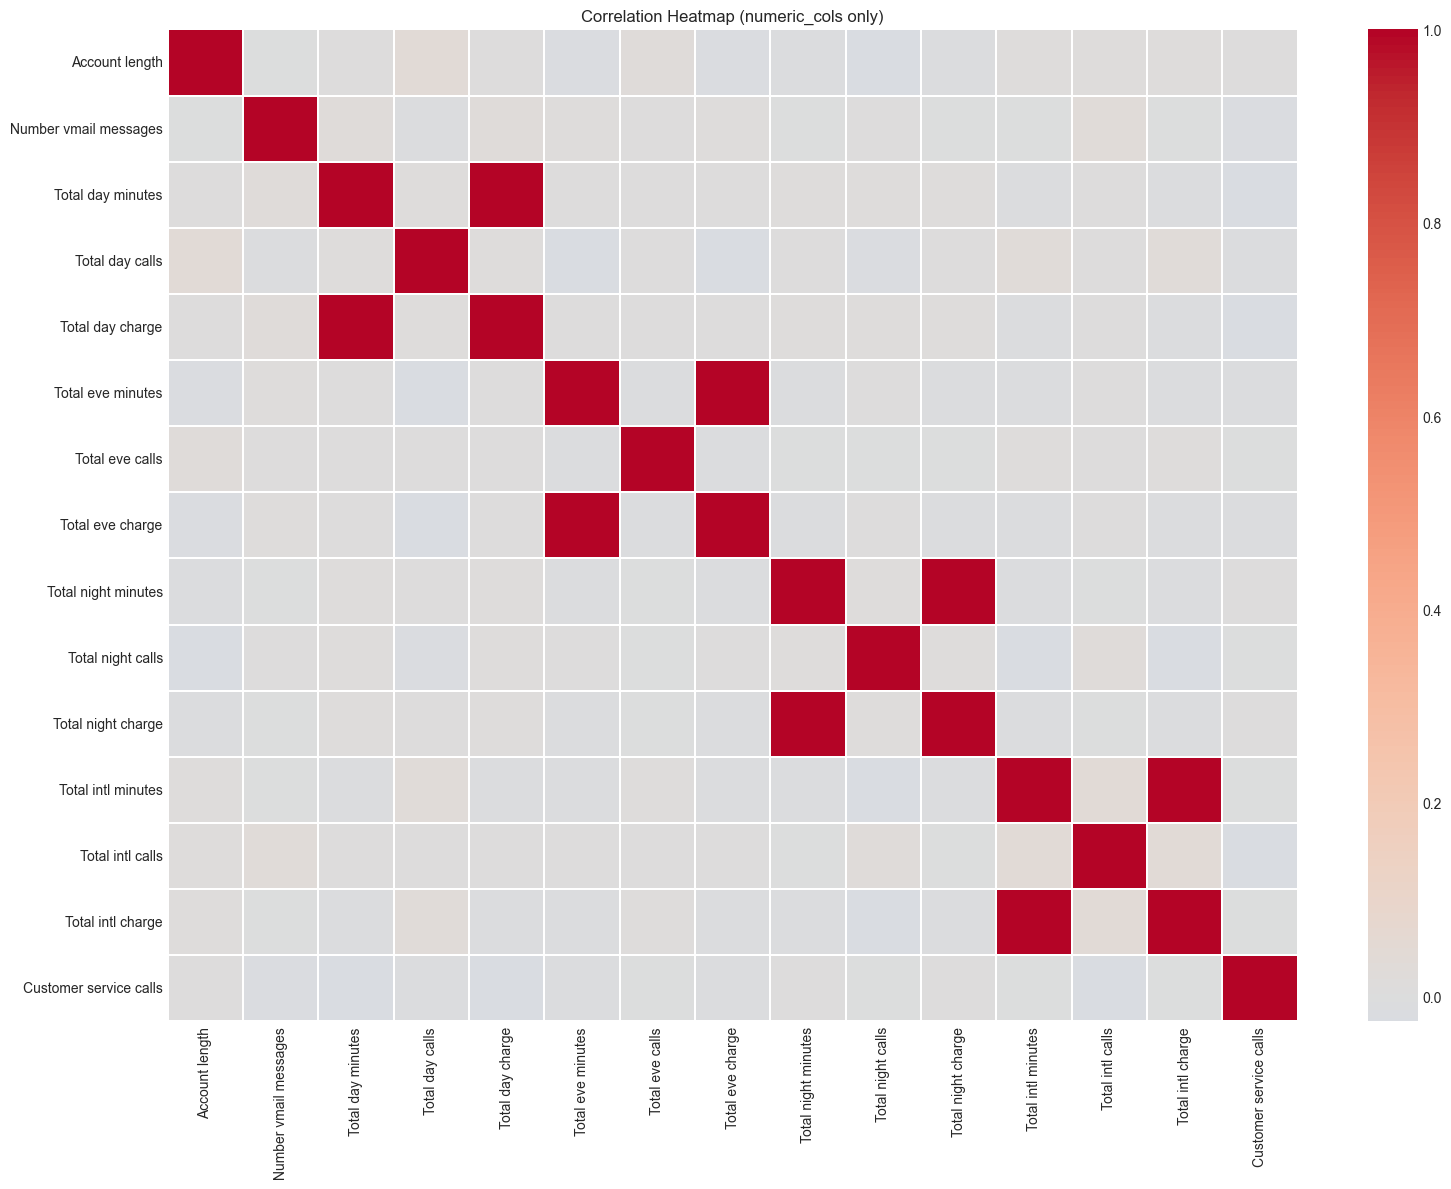

In [ ]:
numeric_df = df[numeric_cols]


corr = numeric_df.corr()


plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.2
)
plt.title("Correlation Heatmap (numeric_cols only)")
plt.tight_layout()
plt.show()

Total day minutes ↔ Total day charge ≈ 1

Total eve minutes ↔ Total eve charge ≈ 1

Total night minutes ↔ Total night charge ≈ 1

Total intl minutes ↔ Total intl charge ≈ 1

엄청 강한 상관관계 (중복정보) charge 컬럼 삭제요망

charge = minutes x 요금

In [ ]:
key_numeric = [
    'Customer service calls',
    'Total day minutes',
    'Total intl minutes',
    'Number vmail messages'
]

In [ ]:
# for col in key_numeric:
#     plt.figure(figsize=(5, 3))
#     sns.histplot(df[col], bins=30, kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()

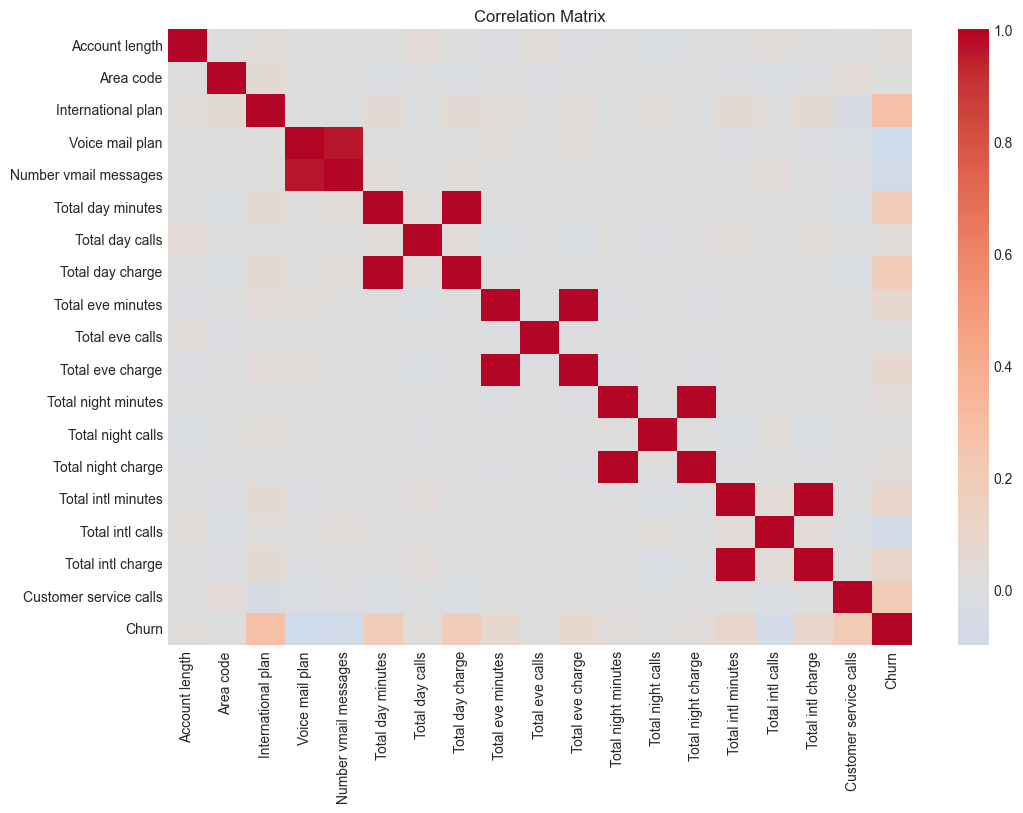

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes('number').corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

음성 사서함 가입 여부와 음성 사서함저장 메세지 수의 상관관계가 매우 높아서 저장된 메세지수 하나로만 봐도 데이터 손실 없을것 같음

state, charge 4가지 , area code, account length 의 변수 삭제 


핵심관련 변수
Total day minutes        1.34e-15
Total day charge         1.34e-15
Customer service calls   1.38e-13
Number vmail messages    8.03e-07
Total intl minutes       9.37e-06
Total intl charge        9.36e-06

약간의 관련 변수
Total eve minutes        1.81e-04
Total eve charge         1.82e-04
Total intl calls         3.57e-04

약한 관련 변수
Total night minutes      6.74e-02
Total night charge       6.75e-02

관련 없음
Account length           0.3667
Total day calls          0.3787
Total night calls        0.5384
Total eve calls          0.9352

### 랜덤 포레스트 모델링 

In [ ]:
def make_cs_group(x):
    if x == 0:
        return "0"
    elif 1 <= x <= 3:
        return "1-3"
    else:
        return "4+"

df["CS_group"] = df["Customer service calls"].apply(make_cs_group)
df_test["CS_group"] = df_test["Customer service calls"].apply(make_cs_group)

In [ ]:
cols_to_drop = [
    'State', # 지역변수 영향 미미
    'Area code',
    'Account length', 
    'Voice mail plan',
    'Customer service calls',
    'International plan',

    # #charge 계열 (minutes와 중복)
    'Total day charge',
    'Total eve charge',
    'Total night charge',
    'Total intl charge',

    # # #calls 계열 (전화 횟수는 영향이 미미)
    'Total day calls',
    'Total eve calls',
    'Total night calls'
]

df_train_final = df.drop(columns=cols_to_drop, errors="ignore")
df_test_final  = df_test.drop(columns=cols_to_drop, errors="ignore")

#  train 기준으로 test 컬럼/순서 맞추기 
df_test_final = df_test_final.reindex(columns=df_train_final.columns)

print("✅ same columns:", df_train_final.columns.equals(df_test_final.columns))
print("Train:", df_train_final.shape, "Test:", df_test_final.shape)

✅ same columns: True
Train: (2666, 8) Test: (667, 8)


In [ ]:
target = "Churn"

X_train = df_train_final.drop(columns=[target]).copy()
y_train = df_train_final[target].copy()

X_test  = df_test_final.drop(columns=[target]).copy()
y_test  = df_test_final[target].copy()

# Yes/No -> 0/1 (International plan만 남아있을 가능성 큼)
if "International plan" in X_train.columns:
    X_train["International plan"] = (X_train["International plan"] == "Yes").astype(int)
    X_test["International plan"]  = (X_test["International plan"] == "Yes").astype(int)

# CS_group -> ordinal
cs_map = {"0": 0, "1-3": 1, "4+": 2}
X_train["CS_group"] = X_train["CS_group"].astype(str).str.strip().map(cs_map).fillna(1)
X_test["CS_group"]  = X_test["CS_group"].astype(str).str.strip().map(cs_map).fillna(1)

# 마지막 sanity check
assert X_train.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0
print("✅ X/y ready:", X_train.shape, X_test.shape)

✅ X/y ready: (2666, 7) (667, 7)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
test_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"✅ Test AUC: {test_auc:.4f}")

✅ Test AUC: 0.8967


이 모델은 이탈 고객이 비이탈 고객보다 더 높은 점수를 받을 확률이 약 89.5%이다.

In [ ]:
proba = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report
# 임계값 0.5
y_pred_05 = (proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred_05))

# 임계값 0.3
y_pred_05 = (proba >= 0.3).astype(int)
print(classification_report(y_test, y_pred_05))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       572
        True       0.96      0.67      0.79        95

    accuracy                           0.95       667
   macro avg       0.95      0.83      0.88       667
weighted avg       0.95      0.95      0.95       667

              precision    recall  f1-score   support

       False       0.96      0.95      0.95       572
        True       0.71      0.76      0.73        95

    accuracy                           0.92       667
   macro avg       0.83      0.85      0.84       667
weighted avg       0.92      0.92      0.92       667




### 성능 평가 


**평가 지표**:
- **Precision (정밀도)**: 모델이 "비이탈고객 or 이탈고객"이라고 예측한 것 중 실제로 "비이탈고객 or 이탈고객"인 비율
- **Recall (재현율)**: 실제 "비이탈고객 or 이탈고객" 중 모델이 맞춘 비율
- **F1-Score**: Precision과 Recall의 조화평균

**결과 해석**:  
- 비이탈 그룹은 예측과 실제 모델이 맞춘 비율이 거의 완벽하지만
- 이탈 그룹은 예측한 고객에 대해선 높은확률로 맞추지만 실제 이탈 고객의 33%가량을 놓친다.
- 보수적인 모델로 판단이 되어 임계값을 0.5에서 0.3으로 낮춘 것도 비교 해보았다. 
- 임계값을 0.3을 낮추었을때 정밀도와 재현율이 비슷해지지만 정밀도가 많이 낮아졌다.
- 임계값을 0.5로 했을때 가장 밸런스가 좋은것으로 판단됨 

In [ ]:
import pandas as pd

# rf는 이미 fit된 모델이라고 가정
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("✅ Top 20 Feature Importances")
print(fi.head(20))


✅ Top 20 Feature Importances
Total day minutes        0.298227
Total eve minutes        0.157995
CS_group                 0.140750
Total intl minutes       0.135430
Total night minutes      0.131270
Total intl calls         0.075503
Number vmail messages    0.060826
dtype: float64


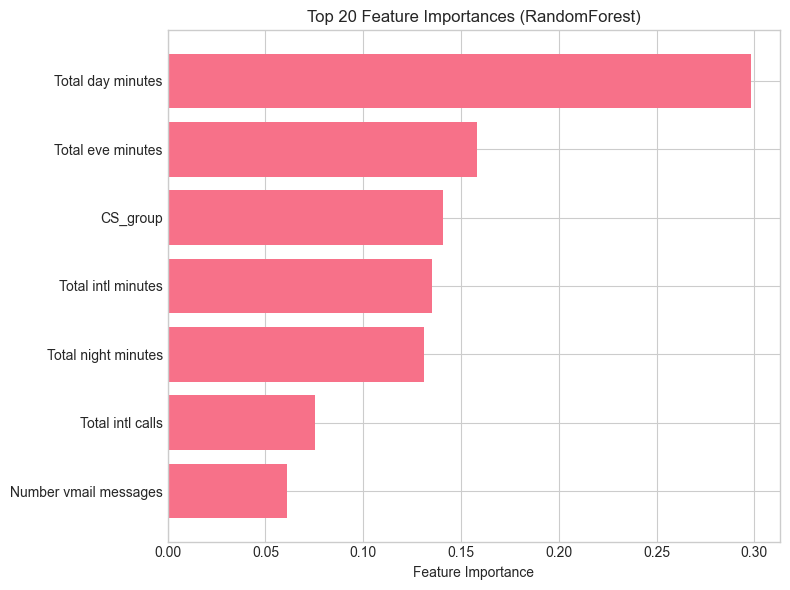

In [ ]:
import matplotlib.pyplot as plt

top_n = 20
fi_top = fi.head(top_n).sort_values()  # barh는 작은값->큰값이 보기 좋아서 정렬

plt.figure(figsize=(8, 6))
plt.barh(fi_top.index, fi_top.values)
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()


### Total day minutes
- 낮 시간 통화량이 이탈 예측에 가장 큰 영향을 미침
- 낮 시간 통화량이 많은 고객은 요금 체감이 크거나 서비스 품질에 대한 기대 수준이 높아, 불만 발생 시 이탈로 이어질 가능성이 높다.

### Total eve minutes
- 저녁 시간 통화량 역시 주요 이탈 신호
- 업무 외 시간대 사용량이 높은 고객은 서비스 의존도가 높아, 대체 서비스로의 이동 가능성이 이탈로 연결될 수 있다.

### CS_group (추가변수)
- 고객센터에 자주 문의한 고객은 서비스 불만이나 문제를 반복적으로 경험했을 가능성이 높으며, 이는 이탈의 직접적인 전조 신호로 작용한다.

### Total intl minutes / Total intl calls
- 국제 통화 사용량 및 빈도
- 국제 통화를 자주 이용하는 고객은 요금 민감도가 높거나 대체 통신 서비스로 전환할 가능성이 높아 이탈 위험이 상대적으로 큰 고객군으로 해석할 수 있다.

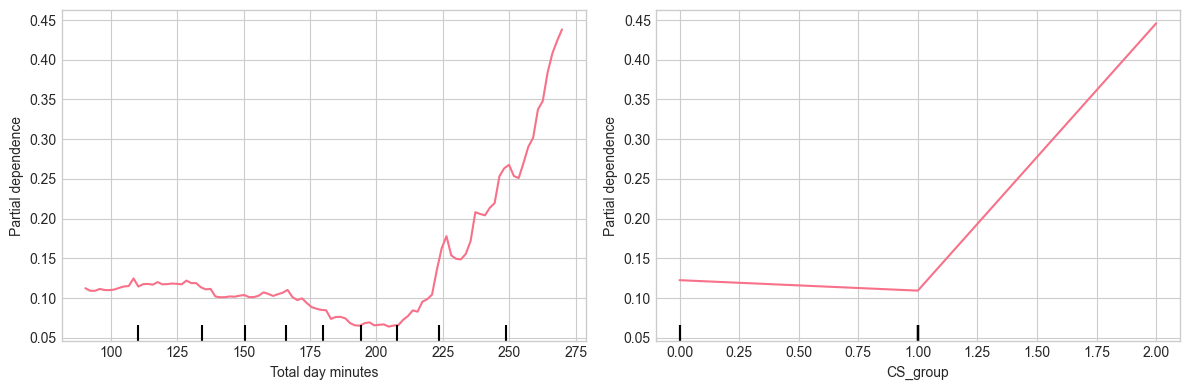

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = [
    "Total day minutes",
    "CS_group",
]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    features=features,
    ax=ax
)

plt.tight_layout()
plt.show()


### Total day minutes pdp 
- 대략 220 분 이상 사용량이 나오는 고객들부터 급격히 이탈률이 올라감 사용량이 많아지니 요금제에 대한 부담감으로 사료 됨
- 220분 이상 고객 → 이탈 위험군 모니터링 시작
- 250분 이상 고객 → 즉시 개입 대상

### Cs_group pdp 
0 → 고객센터 문의 없음 → 이탈 확률 약 12%

1 → 1~3회 → 거의 변화 없음

2 → 4회 이상 → 이탈 확률 급상승(≈45%)

- 4 회 이상으로 고객센터 문의를 하는 고객들부터 급격히 이탈률이 올라감 
- 반복 문의 원인 분석 + 전담 응대

## 결론 
낮 통화량이 많으면서 고객센터 문의가 반복되는 고객은 이탈 확률이 급격히 상승하는 고위험군으로 사전 대응이 없을 경우 단기 이탈 가능성이 높다.
- 전담 상담

- 요금/플랜 재조정 제안

- 불만 원인 즉시 해결